In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# explore
engine.execute('SELECT * FROM Station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_analysis = session.query(Measurement.date, Measurement.prcp).\
               filter(func.strftime("%Y-%m-%d", Measurement.date)>='2016-08-23').all()
precip_df = pd.DataFrame(precip_analysis).fillna(0)

In [13]:
precip_df.date=pd.to_datetime(precip_df.date,infer_datetime_format=True)

In [14]:
precip_df=precip_df.sort_values('date')

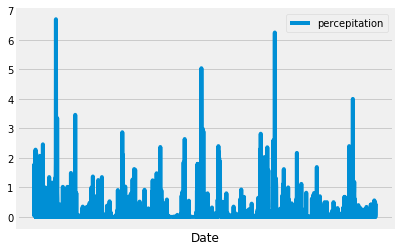

<Figure size 432x288 with 0 Axes>

In [15]:
x_axis=np.arange(len(precip_df.date))
y_axis=pd.to_numeric(precip_df.prcp)
plt.plot(x_axis,y_axis,label="percepitation")
plt.xlabel("Date")
plt.xticks([])
plt.legend()
plt.show()
plt.savefig('image/Figure 1.png')

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
ans_number=session.query(Station.station).count()
print(f'There are {ans_number} stations available in this dataset.')

There are 9 stations available in this dataset.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Station_1= session.query(Measurement.station, Measurement.prcp, Measurement.tobs).all()
Station_1=pd.DataFrame(Station_1).fillna(0)
Station_active=Station_1.groupby("station").count().sort_values('tobs',ascending=False)
Station_active

,prcp,tobs
station,,
USC00519281,2772,2772
USC00519397,2724,2724
USC00513117,2709,2709
USC00519523,2669,2669
USC00516128,2612,2612
USC00514830,2202,2202
USC00511918,1979,1979
USC00517948,1372,1372
USC00518838,511,511


In [19]:
data=Station_active.reset_index()
most_active_station=data.iloc[0,0]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station=session.query(Measurement.station, Measurement.prcp,Measurement.tobs).\
         filter(Measurement.station == most_active_station).\
         order_by(Measurement.tobs).all()
active_station=pd.DataFrame(active_station)
active_station_lowest=active_station['tobs'].min()
active_station_highest=active_station['tobs'].max()
avg_active_station=active_station['tobs'].mean()

In [21]:
print(f"the lowest temperature of {most_active_station} station is {active_station_lowest}")
print(f"the highest temperature of {most_active_station} station is {active_station_highest}")
print(f"the average temperature of {most_active_station} station is {avg_active_station}")

the lowest temperature of USC00519281 station is 54.0
the highest temperature of USC00519281 station is 85.0
the average temperature of USC00519281 station is 71.66378066378067


In [22]:
active_station_temp=session.query(Measurement.tobs).\
         filter(Measurement.station == most_active_station, func.strftime("%Y-%m-%d", Measurement.date)>="2016-08-23").all()

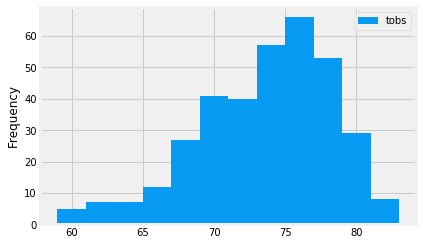

<Figure size 432x288 with 0 Axes>

In [23]:
temperatures = [temp[0] for temp in active_station_temp]     
plt.hist(temperatures, bins=12, color='xkcd:azure', label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.show()
plt.savefig('image/Figure 2.png')

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
result=calc_temps('2016-08-23','2017-08-23')

In [26]:
min_result=result[0][0]
avg_result=result[0][1]
max_result=result[0][2]

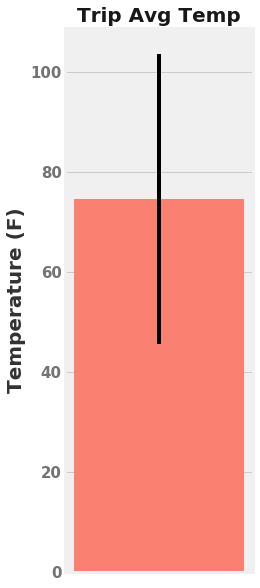

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=[3,10])
yerr=max_result-min_result
plt.bar(1, avg_result, yerr=yerr, color='salmon')
plt.ylabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks([],fontsize=15, fontweight="bold", alpha=0.55);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Trip Avg Temp',fontweight="bold", alpha=0.9, fontsize=20);

plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def station_sum_prcp(start_date, end_date):  
    all_df=session.query(Station.station,Station.name,func.sum(Measurement.prcp), Station.longitude, Station.latitude, Station.elevation).\
      filter(Measurement.station == Station.station).\
      filter(Measurement.date>=start_date, Measurement.date <= end_date).\
      group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
    all_df=pd.DataFrame(all_df,columns=['station','name','total_prcp','longitude', 'latitude', 'elevation'])
    return all_df

In [29]:
station_sum_prcp("2016-08-23","2017-08-23")

,station,name,total_prcp,longitude,latitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",147.81,-157.80250,21.33310,152.4
1,USC00519281,"WAIHEE 837.5, HI US",70.03,-157.84889,21.45167,32.9
2,USC00513117,"KANEOHE 838.1, HI US",48.51,-157.80150,21.42340,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",38.01,-157.71139,21.33556,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",33.24,-157.83740,21.52130,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",16.09,-157.81680,21.27160,3.0
6,USC00517948,"PEARL CITY, HI US",4.59,-157.97510,21.39340,11.9


## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    date=str(date).split(" ")[0]
    sel = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%Y-%m-%d", Measurement.date) == date).all()

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
def cal_day(start_date, end_date):
    trip=pd.to_datetime(end_date)-pd.to_datetime(start_date)
    date=start_date
    normals=[]
    d=0
    for d in range(trip.days):
        normals.append(daily_normals(date))
        date = pd.to_datetime(date) + dt.timedelta(days=1)
    return normals  

In [37]:
rainfall_daily=cal_day("2017-01-01","2017-01-07")

In [38]:
rainfall=[]
for i in range(len(rainfall_daily)):
    rainfall.append(rainfall_daily[i][0])

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
rainfall=pd.DataFrame(rainfall,columns = ['Date' , 'Min_tobs', 'Avg_tobs','Max_tobs'])
rainfall=rainfall.set_index('Date')

In [40]:
rainfall_daily

[[('2017-01-01', 62.0, 69.33333333333333, 74.0)],
 [('2017-01-02', 66.0, 69.2, 74.0)],
 [('2017-01-03', 63.0, 67.66666666666667, 73.0)],
 [('2017-01-04', 62.0, 67.16666666666667, 73.0)],
 [('2017-01-05', 63.0, 67.5, 72.0)],
 [('2017-01-06', 62.0, 67.66666666666667, 74.0)]]

<Figure size 7200x3600 with 0 Axes>

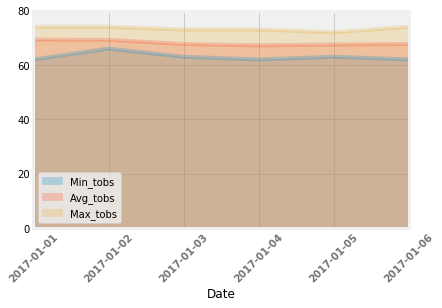

<Figure size 432x288 with 0 Axes>

In [43]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize=[100,50])
rainfall.plot(kind='area', alpha=0.25, legend=True, stacked=False, use_index=True,fontsize=10,
                      grid=True)
plt.xticks(fontsize=10, fontweight="bold", alpha=0.55, rotation=45)
plt.yticks(np.arange(0, 100, 20))
plt.show()
plt.savefig('image/Figure 3.png')